# Test Bar Chart Extractor - 10 Charts

Notebook để test module `BarChartExtractor` trên 10 ảnh đầu tiên và so sánh với ground truth.

## Mục tiêu:
- Extract data từ 10 bar charts đầu tiên
- So sánh kết quả với annotations
- Tính toán độ chính xác cho từng chart
- Tổng hợp kết quả và đánh giá

In [1]:
# Setup
import sys
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# Add project root to path
_cwd = Path().resolve()
project_root = _cwd if (_cwd / "src").is_dir() else _cwd.parent
sys.path.insert(0, str(project_root))

# Import modules
from src.extraction.bar_extractor import BarChartExtractor
from src.preprocessing.image_utils import ImagePreprocessor

print("Setup complete!")

Setup complete!


In [2]:
# Initialize extractor
extractor = BarChartExtractor()
print("BarChartExtractor initialized successfully!")

Using CPU. Note: This module is much faster with a GPU.


BarChartExtractor initialized successfully!


In [3]:
# Load annotations
annotation_file = project_root / "data" / "annotations" / "bar_charts.json"
with open(annotation_file, 'r', encoding='utf-8') as f:
    annotations = json.load(f)

print(f"Loaded {len(annotations)} annotations")

Loaded 500 annotations


In [4]:
# Get first 10 chart files
chart_dir = project_root / "data" / "raw" / "bar_charts"
chart_files = sorted(chart_dir.glob("chart_*.png"))[:100]

print(f"Found {len(chart_files)} chart files to test:")
for i, f in enumerate(chart_files, 1):
    print(f"  {i}. {f.name}")

Found 100 chart files to test:
  1. chart_0001.png
  2. chart_0002.png
  3. chart_0003.png
  4. chart_0004.png
  5. chart_0005.png
  6. chart_0006.png
  7. chart_0007.png
  8. chart_0008.png
  9. chart_0009.png
  10. chart_0010.png
  11. chart_0011.png
  12. chart_0012.png
  13. chart_0013.png
  14. chart_0014.png
  15. chart_0015.png
  16. chart_0016.png
  17. chart_0017.png
  18. chart_0018.png
  19. chart_0019.png
  20. chart_0020.png
  21. chart_0021.png
  22. chart_0022.png
  23. chart_0023.png
  24. chart_0024.png
  25. chart_0025.png
  26. chart_0026.png
  27. chart_0027.png
  28. chart_0028.png
  29. chart_0029.png
  30. chart_0030.png
  31. chart_0031.png
  32. chart_0032.png
  33. chart_0033.png
  34. chart_0034.png
  35. chart_0035.png
  36. chart_0036.png
  37. chart_0037.png
  38. chart_0038.png
  39. chart_0039.png
  40. chart_0040.png
  41. chart_0041.png
  42. chart_0042.png
  43. chart_0043.png
  44. chart_0044.png
  45. chart_0045.png
  46. chart_0046.png
  47. chart_

In [5]:
def compare_results(extracted: Dict, ground_truth: Dict) -> Dict:
    """
    So sánh kết quả extracted với ground truth
    Returns: Dictionary với các metrics
    """
    gt_metadata = ground_truth.get('metadata', {})
    
    # Title comparison
    gt_title = gt_metadata.get('title', '')
    ext_title = extracted.get('title', '') or ''
    title_match = gt_title.lower() == ext_title.lower()
    
    # X-label comparison
    gt_xlabel = gt_metadata.get('xlabel', '')
    ext_xlabel = extracted.get('x_axis_label', '') or ''
    xlabel_match = gt_xlabel.lower() == ext_xlabel.lower()
    
    # Y-label comparison
    gt_ylabel = gt_metadata.get('ylabel', '')
    ext_ylabel = extracted.get('y_axis_label', '') or ''
    ylabel_match = gt_ylabel.lower() == ext_ylabel.lower()
    
    # Bars count
    gt_bars = len(gt_metadata.get('categories', []))
    ext_bars = len(extracted.get('data', []))
    bars_match = gt_bars == ext_bars
    
    # Categories comparison
    gt_categories = gt_metadata.get('categories', [])
    ext_categories = [item.get('category', '') for item in extracted.get('data', [])]
    
    # Values comparison
    gt_values = gt_metadata.get('values', [])
    ext_values = [item.get('value', 0) for item in extracted.get('data', [])]
    
    # Calculate accuracy metrics
    category_matches = 0
    value_errors = []
    
    min_len = min(len(gt_categories), len(ext_categories))
    for i in range(min_len):
        if gt_categories[i].lower() == ext_categories[i].lower():
            category_matches += 1
        
        if i < len(gt_values) and i < len(ext_values):
            error = abs(gt_values[i] - ext_values[i])
            value_errors.append(error)
    
    category_accuracy = category_matches / gt_bars if gt_bars > 0 else 0
    avg_value_error = np.mean(value_errors) if value_errors else float('inf')
    max_value_error = np.max(value_errors) if value_errors else float('inf')
    
    return {
        'title_match': title_match,
        'xlabel_match': xlabel_match,
        'ylabel_match': ylabel_match,
        'bars_match': bars_match,
        'gt_bars': gt_bars,
        'ext_bars': ext_bars,
        'category_accuracy': category_accuracy,
        'avg_value_error': avg_value_error,
        'max_value_error': max_value_error,
        'gt_categories': gt_categories,
        'ext_categories': ext_categories,
        'gt_values': gt_values,
        'ext_values': ext_values
    }

print("Comparison function defined")

Comparison function defined


## Process và so sánh từng chart

In [6]:
# Process each chart and compare with ground truth
results = []

for chart_file in chart_files:
    chart_name = chart_file.name
    print(f"\n{'='*60}")
    print(f"Processing: {chart_name}")
    print(f"{'='*60}")
    
    # Find corresponding annotation
    annotation = None
    for ann in annotations:
        if chart_name in ann.get('image', ''):
            annotation = ann
            break
    
    if not annotation:
        print(f"  ⚠️  No annotation found for {chart_name}")
        continue
    
    # Extract data
    try:
        extracted = extractor.extract(str(chart_file), ocr_method='easyocr')
        
        # Compare with ground truth
        comparison = compare_results(extracted, annotation)
        
        # Store results
        results.append({
            'chart_name': chart_name,
            'extracted': extracted,
            'ground_truth': annotation,
            'comparison': comparison
        })
        
        # Print summary
        print(f"  Title: GT='{annotation['metadata']['title']}' | Ext='{extracted.get('title', 'N/A')}' | {'✅' if comparison['title_match'] else '❌'}")
        print(f"  X-label: GT='{annotation['metadata']['xlabel']}' | Ext='{extracted.get('x_axis_label', 'N/A')}' | {'✅' if comparison['xlabel_match'] else '❌'}")
        print(f"  Y-label: GT='{annotation['metadata']['ylabel']}' | Ext='{extracted.get('y_axis_label', 'N/A')}' | {'✅' if comparison['ylabel_match'] else '❌'}")
        print(f"  Bars: GT={comparison['gt_bars']} | Ext={comparison['ext_bars']} | {'✅' if comparison['bars_match'] else '❌'}")
        print(f"  Category Accuracy: {comparison['category_accuracy']:.1%}")
        print(f"  Avg Value Error: {comparison['avg_value_error']:.2f}")
        
    except Exception as e:
        print(f"  ❌ Error processing {chart_name}: {e}")
        import traceback
        traceback.print_exc()

print(f"\n\nProcessed {len(results)} charts successfully")


Processing: chart_0001.png


c:\Users\minht\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


  Title: GT='Monthly Sales' | Ext='Monthly Sales' | ✅
  X-label: GT='Months' | Ext='Months' | ✅
  Y-label: GT='Value' | Ext='Value' | ✅
  Bars: GT=7 | Ext=6 | ❌
  Category Accuracy: 28.6%
  Avg Value Error: 30.52

Processing: chart_0002.png
  Title: GT='Survey Results' | Ext='Survey Results' | ✅
  X-label: GT='Months' | Ext='Months' | ✅
  Y-label: GT='Scores' | Ext='Scores' | ✅
  Bars: GT=8 | Ext=8 | ✅
  Category Accuracy: 100.0%
  Avg Value Error: 3.13

Processing: chart_0003.png
  Title: GT='Market Share' | Ext='Market Share' | ✅
  X-label: GT='Months' | Ext='Months' | ✅
  Y-label: GT='Sales ($)' | Ext='Sales' | ❌
  Bars: GT=6 | Ext=6 | ✅
  Category Accuracy: 83.3%
  Avg Value Error: 0.81

Processing: chart_0004.png
  Title: GT='Monthly Sales' | Ext='Monthly Sales' | ✅
  X-label: GT='Months' | Ext='Months' | ✅
  Y-label: GT='Revenue ($)' | Ext='Revenue' | ❌
  Bars: GT=7 | Ext=6 | ❌
  Category Accuracy: 28.6%
  Avg Value Error: 24.00

Processing: chart_0005.png
  Title: GT='Quarterly 

## Tổng hợp kết quả

In [7]:
# Calculate overall statistics
if results:
    total_charts = len(results)
    
    title_accuracy = sum(1 for r in results if r['comparison']['title_match']) / total_charts
    xlabel_accuracy = sum(1 for r in results if r['comparison']['xlabel_match']) / total_charts
    ylabel_accuracy = sum(1 for r in results if r['comparison']['ylabel_match']) / total_charts
    bars_accuracy = sum(1 for r in results if r['comparison']['bars_match']) / total_charts
    
    avg_category_accuracy = np.mean([r['comparison']['category_accuracy'] for r in results])
    avg_value_error = np.mean([r['comparison']['avg_value_error'] for r in results if r['comparison']['avg_value_error'] != float('inf')])
    
    print("="*60)
    print("TỔNG HỢP KẾT QUẢ")
    print("="*60)
    print(f"\nTổng số charts test: {total_charts}")
    print(f"\nĐộ chính xác:")
    print(f"  Title:        {title_accuracy:.1%} ({sum(1 for r in results if r['comparison']['title_match'])}/{total_charts})")
    print(f"  X-axis Label: {xlabel_accuracy:.1%} ({sum(1 for r in results if r['comparison']['xlabel_match'])}/{total_charts})")
    print(f"  Y-axis Label: {ylabel_accuracy:.1%} ({sum(1 for r in results if r['comparison']['ylabel_match'])}/{total_charts})")
    print(f"  Bars Count:   {bars_accuracy:.1%} ({sum(1 for r in results if r['comparison']['bars_match'])}/{total_charts})")
    print(f"  Categories:   {avg_category_accuracy:.1%} (trung bình)")
    print(f"  Values:       Avg error = {avg_value_error:.2f}")
    print("\n" + "="*60)

TỔNG HỢP KẾT QUẢ

Tổng số charts test: 100

Độ chính xác:
  Title:        100.0% (100/100)
  X-axis Label: 85.0% (85/100)
  Y-axis Label: 51.0% (51/100)
  Bars Count:   64.0% (64/100)
  Categories:   28.9% (trung bình)
  Values:       Avg error = 10.63



## Chi tiết từng chart

In [8]:
# Display detailed results for each chart
for i, result in enumerate(results, 1):
    chart_name = result['chart_name']
    comp = result['comparison']
    gt = result['ground_truth']['metadata']
    ext = result['extracted']
    
    print(f"\n{'='*60}")
    print(f"Chart {i}: {chart_name}")
    print(f"{'='*60}")
    
    print(f"\n📊 Labels:")
    print(f"  Title:  GT='{gt['title']}' | Ext='{ext.get('title', 'N/A')}' | {'✅' if comp['title_match'] else '❌'}")
    print(f"  X-axis: GT='{gt['xlabel']}' | Ext='{ext.get('x_axis_label', 'N/A')}' | {'✅' if comp['xlabel_match'] else '❌'}")
    print(f"  Y-axis: GT='{gt['ylabel']}' | Ext='{ext.get('y_axis_label', 'N/A')}' | {'✅' if comp['ylabel_match'] else '❌'}")
    
    print(f"\n📈 Bars: GT={comp['gt_bars']} | Extracted={comp['ext_bars']} | {'✅' if comp['bars_match'] else '❌'}")
    
    print(f"\n📋 Categories (Accuracy: {comp['category_accuracy']:.1%}):")
    min_len = min(len(comp['gt_categories']), len(comp['ext_categories']))
    for j in range(min_len):
        match = '✅' if comp['gt_categories'][j].lower() == comp['ext_categories'][j].lower() else '❌'
        print(f"  {j+1}. GT='{comp['gt_categories'][j]}' | Ext='{comp['ext_categories'][j]}' | {match}")
    
    if len(comp['gt_categories']) > len(comp['ext_categories']):
        for j in range(len(comp['ext_categories']), len(comp['gt_categories'])):
            print(f"  {j+1}. GT='{comp['gt_categories'][j]}' | Ext='MISSING' | ❌")
    elif len(comp['ext_categories']) > len(comp['gt_categories']):
        for j in range(len(comp['gt_categories']), len(comp['ext_categories'])):
            print(f"  {j+1}. GT='MISSING' | Ext='{comp['ext_categories'][j]}' | ❌")
    
    print(f"\n💰 Values (Avg Error: {comp['avg_value_error']:.2f}):")
    min_len = min(len(comp['gt_values']), len(comp['ext_values']))
    for j in range(min_len):
        error = abs(comp['gt_values'][j] - comp['ext_values'][j])
        match = '✅' if error < 2.0 else '⚠️' if error < 5.0 else '❌'
        print(f"  {j+1}. GT={comp['gt_values'][j]:.2f} | Ext={comp['ext_values'][j]:.2f} | Error={error:.2f} | {match}")


Chart 1: chart_0001.png

📊 Labels:
  Title:  GT='Monthly Sales' | Ext='Monthly Sales' | ✅
  X-axis: GT='Months' | Ext='Months' | ✅
  Y-axis: GT='Value' | Ext='Value' | ✅

📈 Bars: GT=7 | Extracted=6 | ❌

📋 Categories (Accuracy: 28.6%):
  1. GT='Mar' | Ext='Mar' | ✅
  2. GT='Apr' | Ext='Apr' | ✅
  3. GT='May' | Ext='Jun' | ❌
  4. GT='Jun' | Ext='Jul' | ❌
  5. GT='Jul' | Ext='Aug' | ❌
  6. GT='Aug' | Ext='Sep' | ❌
  7. GT='Sep' | Ext='MISSING' | ❌

💰 Values (Avg Error: 30.52):
  1. GT=54.66 | Ext=55.43 | Error=0.77 | ✅
  2. GT=58.71 | Ext=59.43 | Error=0.72 | ✅
  3. GT=5.37 | Ext=50.29 | Error=44.92 | ❌
  4. GT=49.47 | Ext=0.00 | Error=49.47 | ❌
  5. GT=13.67 | Ext=70.14 | Error=56.47 | ❌
  6. GT=69.23 | Ext=100.00 | Error=30.77 | ❌

Chart 2: chart_0002.png

📊 Labels:
  Title:  GT='Survey Results' | Ext='Survey Results' | ✅
  X-axis: GT='Months' | Ext='Months' | ✅
  Y-axis: GT='Scores' | Ext='Scores' | ✅

📈 Bars: GT=8 | Extracted=8 | ✅

📋 Categories (Accuracy: 100.0%):
  1. GT='Feb' | Ex

## Visualization - So sánh số lượng bars

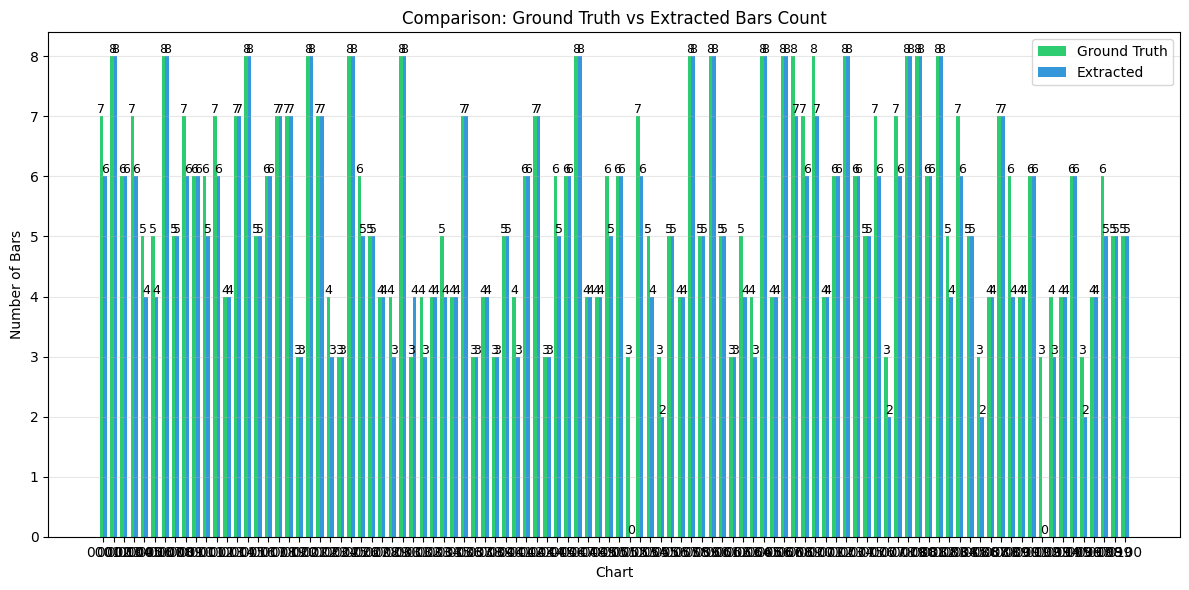

In [9]:
# Create visualization comparing GT vs Extracted bars
if results:
    chart_names = [r['chart_name'].replace('chart_', '').replace('.png', '') for r in results]
    gt_bars = [r['comparison']['gt_bars'] for r in results]
    ext_bars = [r['comparison']['ext_bars'] for r in results]
    
    x = np.arange(len(chart_names))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, gt_bars, width, label='Ground Truth', color='#2ecc71')
    bars2 = ax.bar(x + width/2, ext_bars, width, label='Extracted', color='#3498db')
    
    ax.set_xlabel('Chart')
    ax.set_ylabel('Number of Bars')
    ax.set_title('Comparison: Ground Truth vs Extracted Bars Count')
    ax.set_xticks(x)
    ax.set_xticklabels(chart_names)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## Visualization - Accuracy Metrics

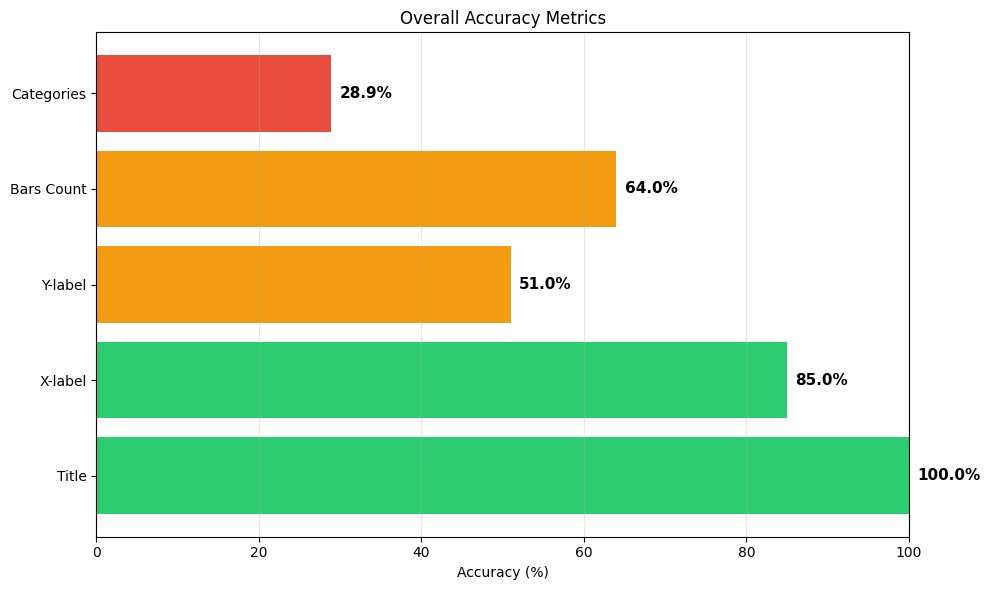

In [10]:
# Create accuracy metrics visualization
if results:
    metrics = ['Title', 'X-label', 'Y-label', 'Bars Count', 'Categories']
    accuracies = [
        title_accuracy * 100,
        xlabel_accuracy * 100,
        ylabel_accuracy * 100,
        bars_accuracy * 100,
        avg_category_accuracy * 100
    ]
    
    colors = ['#e74c3c' if acc < 50 else '#f39c12' if acc < 80 else '#2ecc71' for acc in accuracies]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(metrics, accuracies, color=colors)
    
    ax.set_xlabel('Accuracy (%)')
    ax.set_title('Overall Accuracy Metrics')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, acc) in enumerate(zip(bars, accuracies)):
        ax.text(acc + 1, i, f'{acc:.1f}%', va='center', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Lưu kết quả vào file JSON

In [11]:
# Save detailed results to JSON
output_file = project_root / "data" / "processed" / "test_results_10_charts.json"

# Prepare summary data
summary_data = {
    'total_charts': len(results),
    'statistics': {
        'title_accuracy': float(title_accuracy) if results else 0,
        'xlabel_accuracy': float(xlabel_accuracy) if results else 0,
        'ylabel_accuracy': float(ylabel_accuracy) if results else 0,
        'bars_accuracy': float(bars_accuracy) if results else 0,
        'avg_category_accuracy': float(avg_category_accuracy) if results else 0,
        'avg_value_error': float(avg_value_error) if results else 0
    },
    'detailed_results': []
}

for result in results:
    summary_data['detailed_results'].append({
        'chart_name': result['chart_name'],
        'extracted': result['extracted'],
        'comparison': {
            'title_match': result['comparison']['title_match'],
            'xlabel_match': result['comparison']['xlabel_match'],
            'ylabel_match': result['comparison']['ylabel_match'],
            'bars_match': result['comparison']['bars_match'],
            'gt_bars': result['comparison']['gt_bars'],
            'ext_bars': result['comparison']['ext_bars'],
            'category_accuracy': float(result['comparison']['category_accuracy']),
            'avg_value_error': float(result['comparison']['avg_value_error']) if result['comparison']['avg_value_error'] != float('inf') else None,
            'max_value_error': float(result['comparison']['max_value_error']) if result['comparison']['max_value_error'] != float('inf') else None
        }
    })

# Save to file
output_file.parent.mkdir(parents=True, exist_ok=True)
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(summary_data, f, indent=2, ensure_ascii=False)

print(f"✅ Results saved to: {output_file}")

✅ Results saved to: C:\Homework\Code File\Python Code File\iView\Chart-understanding\bleh\data\processed\test_results_10_charts.json
